# Cursing and deaths in Tarantino movies - a visual representation

(in progress)

Tarantino movies are well known for a lot of reasons, but one we can all agree on is the crude violence. In this project I'll use [Fivethirtyeight data on cursing and deaths in Tarantino movies](https://github.com/fivethirtyeight/data/tree/master/tarantino) (from Reservoir Dogs to Django Unchained) to plot some nice charts and check if his fame is well deserved.

First I'll import the data and do a little EDA (exploratory data analysis).

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

data = pd.read_csv('tarantino.csv')

In [256]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 4 columns):
movie         1894 non-null object
type          1894 non-null object
word          1704 non-null object
minutes_in    1894 non-null float64
dtypes: float64(1), object(3)
memory usage: 59.3+ KB


In [257]:
data.head()

,movie,type,word,minutes_in
0,Reservoir Dogs,word,dick,0.40
1,Reservoir Dogs,word,dicks,0.43
2,Reservoir Dogs,word,fucked,0.55
3,Reservoir Dogs,word,fucking,0.61
4,Reservoir Dogs,word,bullshit,0.61


The first thing we can notice is that there are missing values in the _word_ column, which makes sense since there should only be a words when the _type_ value is _word_. But from this observation we can see that there are a lot more curse words than deaths.
The second thing is that the data doesn't have the year the movie was released. Even if I end up not using it later, I'll add it now.

In [258]:
print(data.movie.unique())
movies_map = {'Reservoir Dogs': 1992, 'Pulp Fiction': 1994, 'Kill Bill: Vol. 1':2003,
       'Kill Bill: Vol. 2':2004, 'Inglorious Basterds':2009, 'Django Unchained':2012,
       'Jackie Brown':1997} # Year data from wikipedia
data['year'] = data.movie.map(movies_map)

['Reservoir Dogs' 'Pulp Fiction' 'Kill Bill: Vol. 1' 'Kill Bill: Vol. 2'
 'Inglorious Basterds' 'Django Unchained' 'Jackie Brown']


In [259]:
data.sort_values(['year', 'minutes_in'], inplace=True)
data

,movie,type,word,minutes_in,year
0,Reservoir Dogs,word,dick,0.40,1992
1,Reservoir Dogs,word,dicks,0.43,1992
2,Reservoir Dogs,word,fucked,0.55,1992
3,Reservoir Dogs,word,fucking,0.61,1992
4,Reservoir Dogs,word,bullshit,0.61,1992
...,...,...,...,...,...
1517,Django Unchained,word,fucked,159.83,2012
1518,Django Unchained,word,n-word,159.88,2012
1519,Django Unchained,word,n-word,160.20,2012
1520,Django Unchained,word,ass,160.28,2012


In [260]:
types = data.type.unique()
words = data.word.unique()
print(types)
print(words)
print(data.word.value_counts()[data.word.value_counts() > 10])

['word' 'death']
['dick' 'dicks' 'fucked' 'fucking' 'bullshit' 'fuck' 'shit' 'motherfucker'
 'pussy' 'fucks' 'hell' 'jap' 'bastard' 'goddamn' 'motherfuckers'
 'asshole' 'ass' 'assholes' 'n-word ' 'asses' 'bitch' 'fuckup' 'fucker'
 'shitty' 'asshead' 'damn' nan 'damned' 'bitches' 'wetback' 'faggot'
 'cocksucker' 'gook' 'fuckers' 'gooks' 'motherfucking' 'dickless'
 'chickenshit' 'slope' 'fuckhead' 'merde' 'shittiest' 'shitload' 'dumbass'
 'shithead' 'cunt' 'cunts' 'fuckface' 'cockblockery' 'japs' 'jew (verb)'
 'bastards' 'horeshit' 'shitless' 'shitting' 'negro ' 'squaw' 'slut'
 'goddamned' 'jackass' 'horseshit']
fucking          407
shit             221
fuck             213
n-word           179
ass              140
goddamn          113
motherfucker      70
bitch             64
hell              45
damn              37
motherfucking     27
fucked            25
bullshit          15
motherfuckers     15
dick              14
pussy             11
Name: word, dtype: int64


A lot of the words have the same root word and a few are just the plural of another word on the list. To deal with these cases I'll count singular and plural of the same word as one word and I'll add boolean columns for each root word.

In [261]:
replace_map = {'dicks':'dick', 'fucks':'fuck', 'motherfuckers':'motherfucker', 'bastards':'bastard', 
               'assholes':'asshole', 'asses':'ass', 'bitches':'bitch', 'fuckers':'fucker', 'gooks':'gook', 
               'cunts':'cunt', 'goddamned':'goddamn', 'damned':'damn'}
data.replace(replace_map, inplace=True)
data.word.unique()

array(['dick', 'fucked', 'fucking', 'bullshit', 'fuck', 'shit',
       'motherfucker', 'pussy', 'hell', 'jap', 'bastard', 'goddamn',
       'asshole', 'ass', 'n-word ', 'bitch', 'fuckup', 'fucker', 'shitty',
       'asshead', 'damn', nan, 'wetback', 'faggot', 'cocksucker', 'gook',
       'motherfucking', 'dickless', 'chickenshit', 'slope', 'fuckhead',
       'merde', 'shittiest', 'shitload', 'dumbass', 'shithead', 'cunt',
       'fuckface', 'cockblockery', 'japs', 'jew (verb)', 'horeshit',
       'shitless', 'shitting', 'negro ', 'squaw', 'slut', 'jackass',
       'horseshit'], dtype=object)

In [262]:
import warnings
warnings.filterwarnings('ignore')

data.word.fillna('NaN', inplace=True)
data['fuck'] = ['fuck' in w for w in data.word]
data['ass'] = ['ass' in w for w in data.word]
data['shit'] = ['shit' in w for w in data.word]
racial = ['japs', 'jew (verb)', 'n-word ', 'negro']
data['racial'] = [w in racial for w in data.word]
data['death']=[w == 'death' for w in data.type]
data['other']=data.word
for i in range(len(data.word)):
    data['other'][i] = not( data.death[i]+data.fuck[i]+data.ass[i]+data.racial[i]+data.shit[i] )
    
data

,movie,type,word,minutes_in,year,fuck,ass,shit,racial,death,other
0,Reservoir Dogs,word,dick,0.40,1992,False,False,False,False,False,True
1,Reservoir Dogs,word,dick,0.43,1992,False,False,False,False,False,True
2,Reservoir Dogs,word,fucked,0.55,1992,True,False,False,False,False,False
3,Reservoir Dogs,word,fucking,0.61,1992,True,False,False,False,False,False
4,Reservoir Dogs,word,bullshit,0.61,1992,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
1517,Django Unchained,word,fucked,159.83,2012,True,False,False,False,False,False
1518,Django Unchained,word,n-word,159.88,2012,False,False,False,True,False,False
1519,Django Unchained,word,n-word,160.20,2012,False,False,False,True,False,False
1520,Django Unchained,word,ass,160.28,2012,False,True,False,False,False,False


Now that the data looks like this, I'll start with a few plots. The next plot is just an overview of the curse words for each movie.

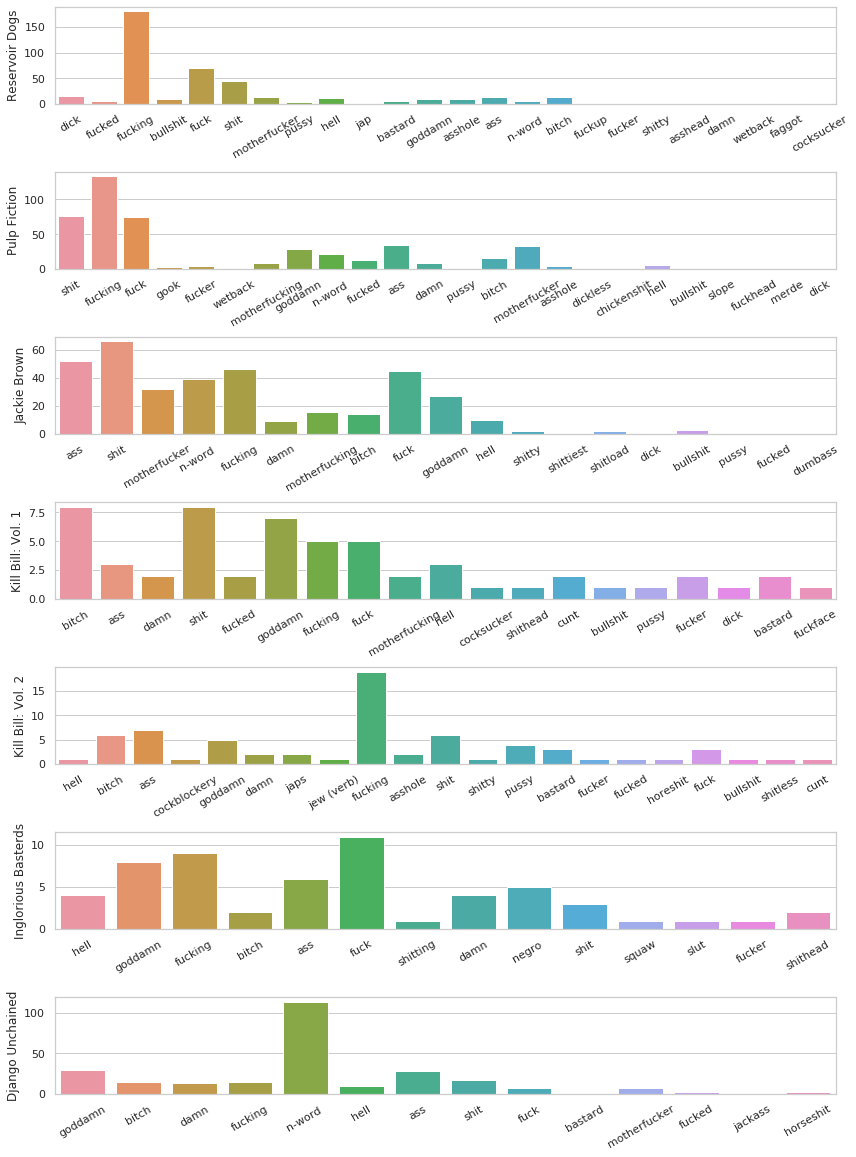

In [263]:
data.word.replace({'NaN':np.nan},inplace=True) # for plotting purposes
sns.set(style='whitegrid', context='notebook')
fig, m = plt.subplots(7, 1, figsize=(14, 20), sharex=False)
plt.subplots_adjust(hspace = 0.7)
movies = data.movie.unique()
x = [data.word[(data.movie == m)] for m in movies]
xa = data.word
for i in range(7):
    m[i] = sns.countplot(x=x[i], data=data, ax=m[i])
    m[i].set_xticklabels(m[i].get_xticklabels(), rotation=30)
    m[i].set_ylabel(movies[i])
    m[i].set_xlabel('')


Now I'll use the boolean columns I created earlier to make it easier to compare movies.

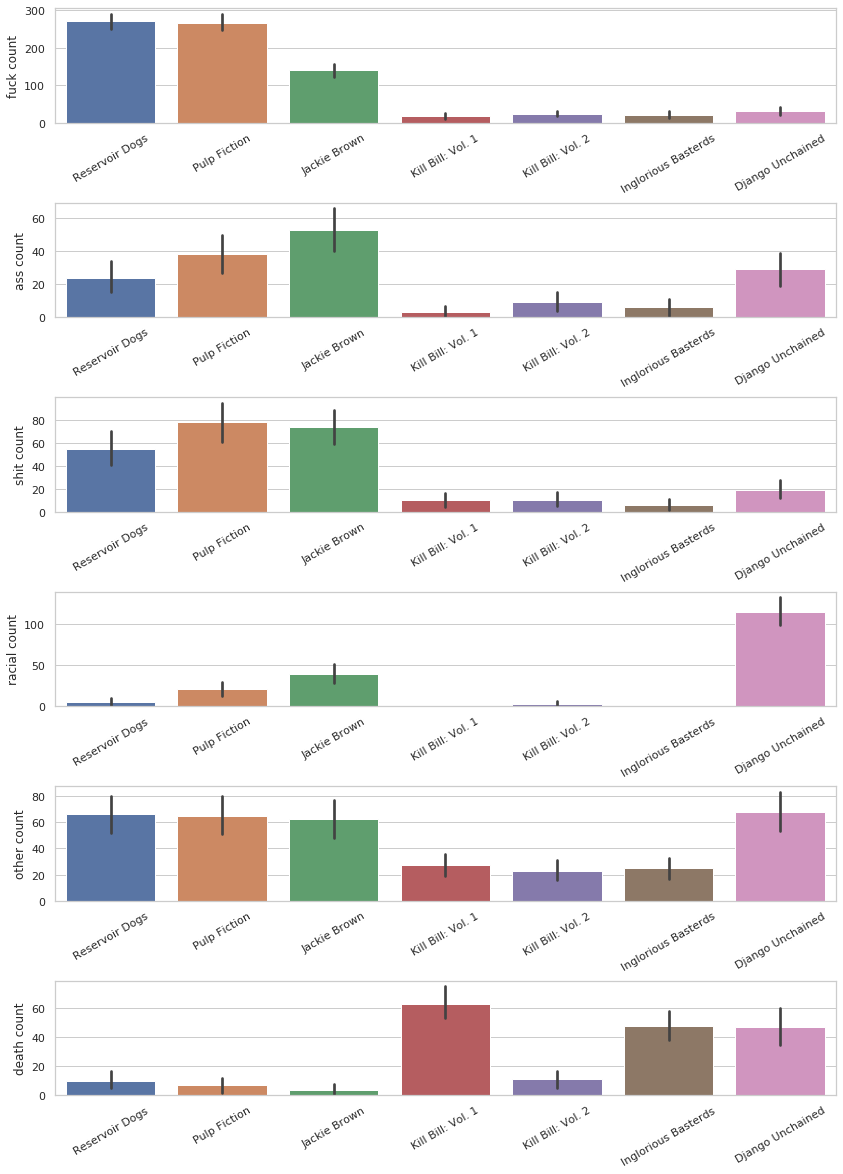

In [286]:
data_bool = data[['movie','fuck', 'ass', 'shit', 'racial', 'other', 'death']]

sns.set(style='whitegrid', context='notebook')
fig1, m1 = plt.subplots(6, 1, figsize=(14, 20), sharex=False)
plt.subplots_adjust(hspace = 0.7)
cols = ['fuck', 'ass', 'shit', 'racial', 'other', 'death']
for i in range(6):
    m1[i] = sns.barplot(x='movie', y=cols[i], data=data_bool, ax=m1[i], estimator=sum)
    m1[i].set_xticklabels(m1[i].get_xticklabels(), rotation=30)
    m1[i].set_ylabel(cols[i]+' count')
    m1[i].set_xlabel('')
    



Fazer: plotar fucks e etc por ano (bar). plotar mortes por ano (bar). plotar racial por filme (bar). plotar pra cada filme, morte por minutos e palavrão por minuto (cores diferentes)